In [1]:
import gymnasium as gym
import numpy as np
import gridworld
import matplotlib.pyplot as plt

def map_to_state(grid_position, grid)-> int:
    max_cols = grid[1]
    return grid_position[0] * max_cols + grid_position[1]

# Politica eps-GREEDY
def eps_greedy(Qs, epsilon) -> int:
    N = len(Qs)

    # Azione random scelta con probabilità epsilon
    if np.random.rand() < epsilon:
        action = np.random.randint(0,N)
        
    # Azione greedy scelta con probabilità 1-epsilon
    else:
        action = greedy(Qs)
        
    return action

# Politica GREEDY: Sceglie sempre l'azione con il valore massimo di Q(s,a)
def greedy(Qs) -> int:

    Qmax = np.max(Qs)
    id = np.where(Qs == Qmax)[0]
    
    if len(id) > 1:
        action = np.random.choice(id)
    else:
        action = id[0]
    return action

def SARSA(Q, s1, a1, r, s2, a2, alpha, gamma, done):
    if not done:
        update = Q[s1][a1] + alpha * (r + gamma * Q[s2][a2] - Q[s1][a1])
    else: 
        update = Q[s1][a1] + alpha * (r + gamma * 0.0 - Q[s1][a1])
    return update

In [11]:
# Parametri decadimento epsilon
max_epsilon = 1.0               
min_epsilon = 0.01            
num_episodes = 2000
decay_rate = 0.0025

# Numero di reward aggiuntive
n_reward = 5

# Parametri di learning
gamma = 1
alpha = 0.1
lambda_ = 0.5

# Vettore contenenti stati e azioni
states = np.array([], dtype=int)
actions = np.array([0, 1, 2, 3])

# Dimensioni griglia
max_rows = 4
max_cols = 12
grid = [max_rows, max_cols]

# Trasformo tutte le posizioni della griglia in stati 
for i in range(max_rows):
    for j in range(max_cols):
        curr_state = map_to_state([i,j], grid)
        states = np.append(states, curr_state)

# Dizionario contenente le Action Value Function per ogni stato
Q ={}
for s in states:
    Q[s] = np.zeros(4)

# Variabili raccolta dati
total_reward_ep = np.zeros(num_episodes)
total_steps = np.zeros(num_episodes)
goal = 0

env = gym.make('Cliff-v0', spawn_reward=True, reward_seed=3, n_reward=n_reward)
for ep in range(num_episodes):
    # Azzero Elegibility traces
    E = {}
    for s in states:
        E[s] = np.zeros(4)
        
    # Decadimento epsilon 
    epsilon = np.max([min_epsilon, max_epsilon * np.exp(-decay_rate * ep)])
    
    # Init ambiente
    curr_cell, info = env.reset()
    curr_state = map_to_state(curr_cell, grid)
    # Scelgo la prima azione
    curr_action = eps_greedy(Q[curr_state], epsilon)
    done = False
    
    while not done:
        # Eseguo l'azione
        next_cell, reward, terminated, truncated, info = env.step(curr_action)
        done = terminated or truncated
        next_state = map_to_state(next_cell, grid)
        next_action = eps_greedy(Q[next_state], epsilon)

        # Update Elegibility traces stato e azione correnti
        if not done:
            delta = reward + gamma * Q[next_state][next_action] - Q[curr_state][curr_action]
            E[curr_state][curr_action] += 1
        else:
            delta = reward + gamma * 0.0 - Q[curr_state][curr_action]
            E[curr_state][curr_action] += 1

        # Update di tutti i valori di Q e decadimento E
        for s in states:
            for a in actions:
                Q[s][a] = Q[s][a] + alpha * delta * E[s][a]
                E[s][a] = gamma * lambda_ * E[s][a]
                
         # Passo allo step successivo 
        curr_state = next_state
        curr_action = next_action

        # Salvo dati step
        if info['goal']:
            goal += 1 
        total_reward_ep[ep] += reward
        total_steps[ep] += 1
        
    # Salvo dati ep 
    if ep < num_episodes - 1:
        total_steps[ep+1] = total_steps[ep]
    if ep % 100 == 0 and ep!= 0:
        print("Episode number: %d Epsilon value: %f" % (ep, epsilon))
        print("Goal reached %d times" % goal)
env.close()

Episode number: 100 Epsilon value: 0.778801
Goal reached 0 times
Episode number: 200 Epsilon value: 0.606531
Goal reached 26 times
Episode number: 300 Epsilon value: 0.472367
Goal reached 56 times
Episode number: 400 Epsilon value: 0.367879
Goal reached 151 times
Episode number: 500 Epsilon value: 0.286505
Goal reached 251 times
Episode number: 600 Epsilon value: 0.223130
Goal reached 351 times
Episode number: 700 Epsilon value: 0.173774
Goal reached 451 times
Episode number: 800 Epsilon value: 0.135335
Goal reached 551 times
Episode number: 900 Epsilon value: 0.105399
Goal reached 651 times
Episode number: 1000 Epsilon value: 0.082085
Goal reached 751 times
Episode number: 1100 Epsilon value: 0.063928
Goal reached 851 times
Episode number: 1200 Epsilon value: 0.049787
Goal reached 951 times
Episode number: 1300 Epsilon value: 0.038774
Goal reached 1051 times
Episode number: 1400 Epsilon value: 0.030197
Goal reached 1151 times
Episode number: 1500 Epsilon value: 0.023518
Goal reached 1

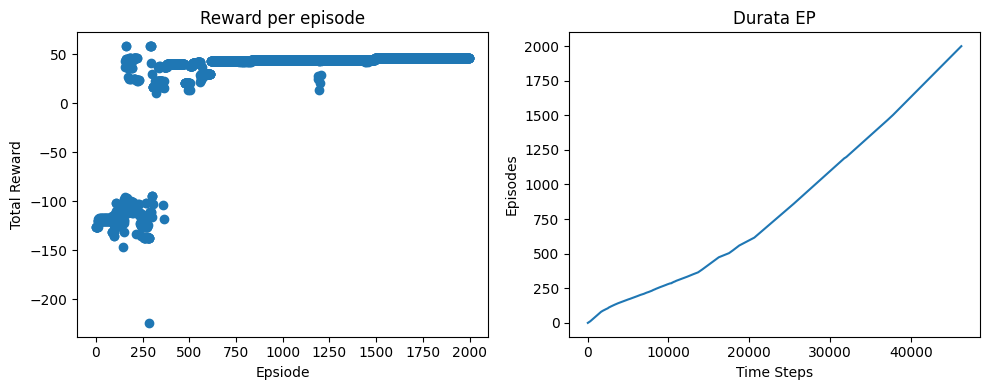

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(np.arange(len(total_reward_ep)), total_reward_ep)

# Aggiungi etichette agli assi
ax1.set_xlabel('Epsiode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Reward per episode')
# Secondo grafico (solo punti) - Ax2
ax2.plot(total_steps, np.arange(len(total_steps)))
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Episodes')
ax2.set_title('Durata EP')


# Mostra entrambi i grafici
plt.tight_layout()
plt.show()

In [15]:
env = gym.make('Cliff-v0', render_mode='human', spawn_reward=True, reward_seed=3, n_reward=n_reward)
for ep in range(3):
    curr_cell, info = env.reset()
    curr_state = map_to_state(curr_cell, grid)
    curr_action = eps_greedy(Q[curr_state], epsilon)
    done = False
    tot_reward = 0
    while not done:
        
        next_cell, reward, terminated, truncated, info = env.step(curr_action)
        done = terminated or truncated
        tot_reward += reward
        if not done:
            next_state = map_to_state(next_cell, grid)
            next_action = eps_greedy(Q[next_state], 0)
            curr_state = next_state
            curr_action = next_action
        
    print("Info: " + str(info))
    print("Total reward: " + str(tot_reward))
env.close()

Info: {'goal': True, 'reward_collected': 3}
Total reward: 46
Info: {'goal': True, 'reward_collected': 3}
Total reward: 46
Info: {'goal': True, 'reward_collected': 3}
Total reward: 46
